---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

# Code 

This notebook demonstrates a workflow for supervised learning, specifically focusing on detecting misinformation using linguistic features and sentiment analysis. The dataset used is the `LIAR` dataset, which contains labeled statements.

## Load and Explore the Dataset

We start by loading the dataset and exploring its structure and contents.

In [1]:
import pandas as pd

# Load the dataset
liar_data = pd.read_csv('../../data/Clean_Data/liar_dataset/train.csv')

# Explore the data
print(liar_data.info())
liar_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10240 non-null  object 
 1   Label                10240 non-null  object 
 2   Statement            10240 non-null  object 
 3   Subjects             10238 non-null  object 
 4   Speaker              10238 non-null  object 
 5   Job_Title            7342 non-null   object 
 6   State_Info           8030 non-null   object 
 7   Party                10238 non-null  object 
 8   Barely_True_Count    10238 non-null  float64
 9   False_Count          10238 non-null  float64
 10  Half_True_Count      10238 non-null  float64
 11  Mostly_True_Count    10238 non-null  float64
 12  Pants_On_Fire_Count  10238 non-null  float64
 13  Context              10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
None


,ID,Label,Statement,Subjects,Speaker,Job_Title,State_Info,Party,Barely_True_Count,False_Count,Half_True_Count,Mostly_True_Count,Pants_On_Fire_Count,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [2]:
liar_data['Label'].value_counts()

Label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

## Preprocess Text Data

Text data is preprocessed to remove stopwords, punctuation, and to tokenize the text. This step is crucial for extracting meaningful features from the text.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('punkt_tab')

# Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stopwords.words('english') + list(string.punctuation)]
    return ' '.join(tokens)

# Apply preprocessing
liar_data['cleaned_text'] = liar_data['Statement'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /Users/pengli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pengli/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Extract Linguistic Features

Linguistic features are extracted using TF-IDF for lexical features and POS tagging for syntactic features.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('averaged_perceptron_tagger_eng')

# Extract lexical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust as needed
X_lexical = vectorizer.fit_transform(liar_data['cleaned_text'])

# Extract syntactic features using POS tagging
def pos_features(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for _, tag in pos_tags)
    return pos_counts

liar_data['pos_features'] = liar_data['cleaned_text'].apply(pos_features)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/pengli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [18]:
liar_data['pos_features']

0                   {'VBZ': 2, 'NNS': 2, 'JJ': 2, 'NN': 2}
1          {'NN': 8, 'VBD': 2, 'JJ': 1, 'VBN': 1, 'CD': 1}
2        {'JJ': 2, 'NN': 6, 'VBZ': 1, 'VBG': 1, 'VB': 1...
3                             {'NN': 7, 'JJ': 2, 'NNS': 1}
4                             {'JJ': 2, 'NN': 2, 'VBD': 1}
                               ...                        
10235              {'JJR': 1, 'NN': 3, 'NNS': 2, 'VBP': 2}
10236               {'NNS': 2, 'VBP': 1, 'NN': 2, 'JJ': 2}
10237    {'VBZ': 2, 'JJ': 5, 'NN': 6, 'VBD': 1, 'NNS': ...
10238                                  {'VBG': 2, 'NN': 4}
10239    {'NN': 5, 'NNS': 3, 'JJ': 1, 'VBG': 2, 'VBP': ...
Name: pos_features, Length: 10240, dtype: object

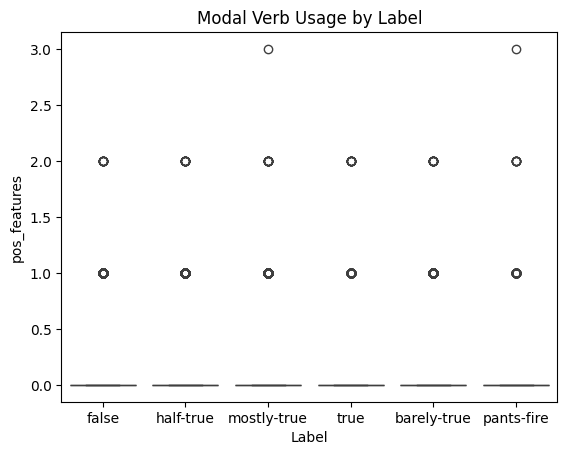

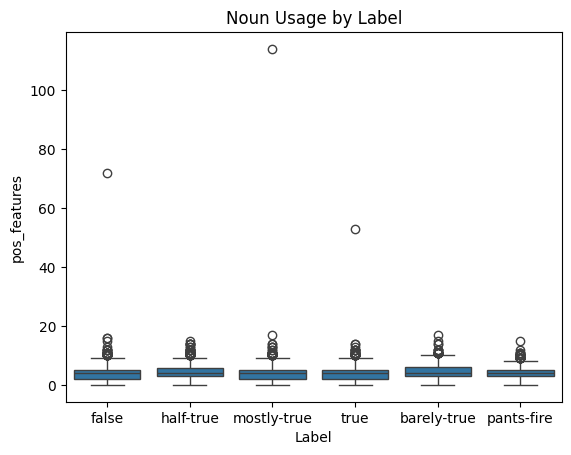

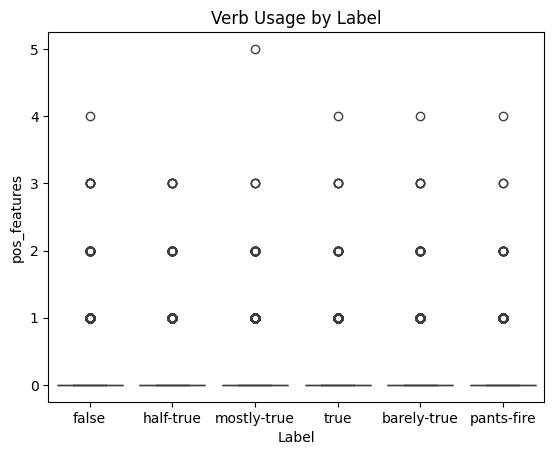

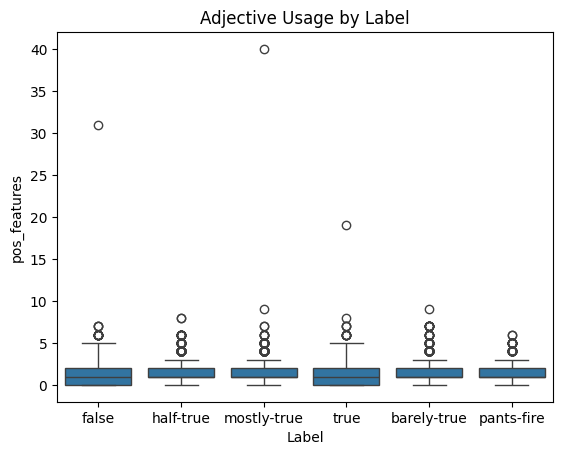

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Label', y=liar_data['pos_features'].apply(lambda x: x['MD']), data=liar_data)
plt.title('Modal Verb Usage by Label')
plt.show()

# Plot the distribution of noun usage by label
sns.boxplot(x='Label', y=liar_data['pos_features'].apply(lambda x: x.get('NN', 0)), data=liar_data)
plt.title('Noun Usage by Label')
plt.show()

# Plot the distribution of verb usage by label
sns.boxplot(x='Label', y=liar_data['pos_features'].apply(lambda x: x.get('VB', 0)), data=liar_data)
plt.title('Verb Usage by Label')
plt.show()

# Plot the distribution of adjective usage by label
sns.boxplot(x='Label', y=liar_data['pos_features'].apply(lambda x: x.get('JJ', 0)), data=liar_data)
plt.title('Adjective Usage by Label')
plt.show()

### POS Tagging Results Interpretation

Part-of-Speech (POS) tagging is a process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context. Here are some common POS tags and their meanings:

- **NN**: Noun, singular or mass
- **NNS**: Noun, plural
- **VB**: Verb, base form
- **VBD**: Verb, past tense
- **VBG**: Verb, gerund or present participle
- **VBZ**: Verb, 3rd person singular present
- **JJ**: Adjective
- **RB**: Adverb
- **IN**: Preposition or subordinating conjunction
- **CD**: Cardinal number

In the context of the `liar_data` DataFrame, the `pos_features` column contains the POS tagging results for each statement. For example:

- **{'VBZ': 2, 'NNS': 2, 'JJ': 2, 'NN': 2}**: This indicates that the statement contains 2 verbs in the 3rd person singular present form, 2 plural nouns, 2 adjectives, and 2 singular nouns.
- **{'NN': 8, 'VBD': 2, 'JJ': 1, 'VBN': 1, 'CD': 1}**: This indicates that the statement contains 8 singular nouns, 2 past tense verbs, 1 adjective, 1 past participle verb, and 1 cardinal number.

These features help in understanding the syntactic structure of the statements and can be used to extract meaningful patterns for detecting misinformation. Yet in this research, POS tagging analysis did not yield strong correlations with truthfulness categories, suggesting that syntactic features alone may not be reliable indicators of misinformation.

## Correlate Features with Misinformation

We split the data into training and testing sets, train a RandomForestClassifier, and evaluate its performance.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data
X = X_lexical  # Or combine with other feature sets
y = liar_data['Label']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 barely-true       0.19      0.15      0.17       482
       false       0.24      0.33      0.28       603
   half-true       0.26      0.27      0.26       675
 mostly-true       0.24      0.28      0.26       582
  pants-fire       0.23      0.11      0.15       236
        true       0.22      0.17      0.19       494

    accuracy                           0.23      3072
   macro avg       0.23      0.22      0.22      3072
weighted avg       0.23      0.23      0.23      3072



Interpretation: While the model’s overall accuracy remains modest, its ability to differentiate between truthfulness categories provides valuable insights into linguistic markers of misinformation.

## Analyze Results

Feature importance is analyzed to understand which linguistic markers are most indicative of misinformation.

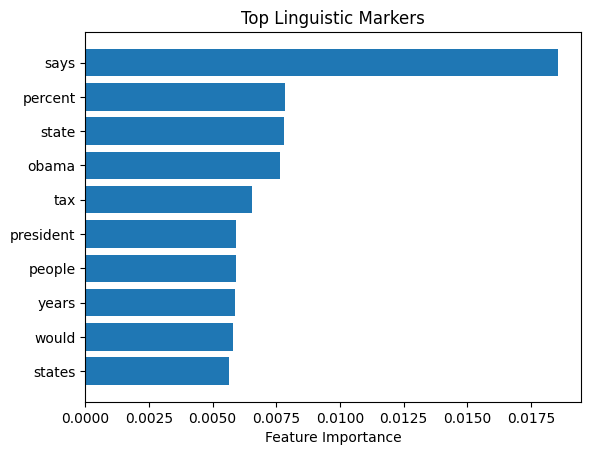

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plot feature importance
feature_importance = clf.feature_importances_
indices = np.argsort(feature_importance)[-10:]  # Top 10 features
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top Linguistic Markers')
plt.show()

### Top Linguistic Markers

The top linguistic markers indicative of misinformation, specifically for the "pants-fire" and "false" labels, are identified through feature importance analysis. These markers are derived from the TF-IDF vectorization of the cleaned text data. The top features for both labels are as follows:

- **states**
- **would**
- **years**
- **people**
- **president**
- **tax**
- **obama**
- **state**
- **percent**
- **says**

These markers highlight common terms that frequently appear in statements labeled as "pants-fire" or "false." Understanding these markers can help in identifying patterns and characteristics of misinformation in textual data.

## Sentiment Analysis

Sentiment analysis is performed using two methods:
- VADER sentiment analysis
- Hugging Face Transformers

The results are visualized to understand the distribution of sentiment across different truthfulness categories.

### Use prebuilt sentiment library VADER

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

liar_data['sentiment_score'] = liar_data['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
liar_data['sentiment_label'] = liar_data['sentiment_score'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pengli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
liar_data.groupby(['Label', 'sentiment_label']).size()

Label        sentiment_label
barely-true  negative           534
             neutral            536
             positive           584
false        negative           579
             neutral            767
             positive           649
half-true    negative           736
             neutral            665
             positive           713
mostly-true  negative           651
             neutral            685
             positive           626
pants-fire   negative           263
             neutral            285
             positive           291
true         negative           508
             neutral            633
             positive           535
dtype: int64

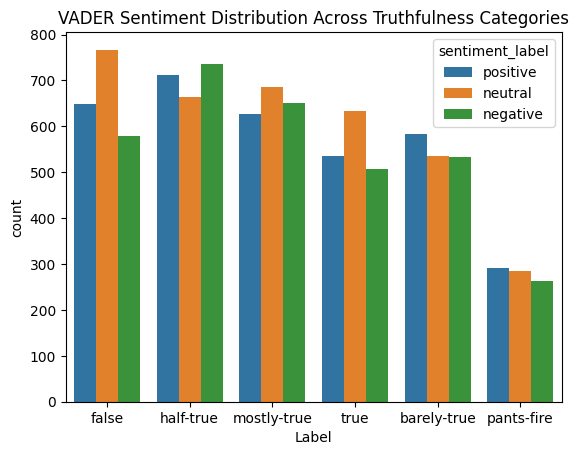

In [ ]:
sns.countplot(data=liar_data, x='Label', hue='sentiment_label')
plt.title('VADER Sentiment Distribution Across Truthfulness Categories')
plt.show()

sentiment_label  positive  negative  positive_to_negative_ratio
Label                                                          
barely-true           584       534                    1.093633
false                 649       579                    1.120898
half-true             713       736                    0.968750
mostly-true           626       651                    0.961598
pants-fire            291       263                    1.106464
true                  535       508                    1.053150


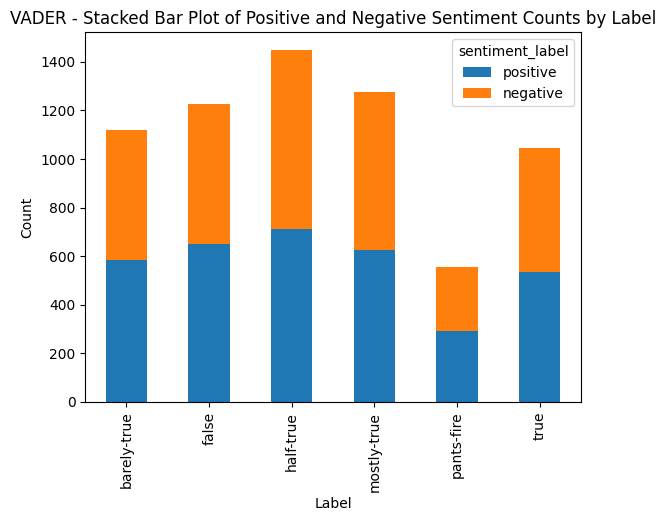

In [28]:
# Group by Label and sentiment_label and count occurrences
sentiment_counts = liar_data.groupby(['Label', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate the ratio of positive to negative sentiment for each label
sentiment_counts['positive_to_negative_ratio'] = sentiment_counts['positive'] / sentiment_counts['negative']

# Display the result
print(sentiment_counts[['positive', 'negative', 'positive_to_negative_ratio']])

# Plot the ratio of positive to negative sentiment for each label
sentiment_counts[['positive', 'negative']].plot(kind='bar', stacked=True)
plt.title('VADER - Stacked Bar Plot of Positive and Negative Sentiment Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Use Hugging Face Transformers

In [10]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")
liar_data['sentiment'] = liar_data['cleaned_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

/Users/pengli/Documents/GitHub/Project-5000-identify-misinformation/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [11]:
liar_data.groupby(['Label', 'sentiment']).size()

Label        sentiment
barely-true  NEGATIVE     1209
             POSITIVE      445
false        NEGATIVE     1394
             POSITIVE      601
half-true    NEGATIVE     1515
             POSITIVE      599
mostly-true  NEGATIVE     1344
             POSITIVE      618
pants-fire   NEGATIVE      636
             POSITIVE      203
true         NEGATIVE     1130
             POSITIVE      546
dtype: int64

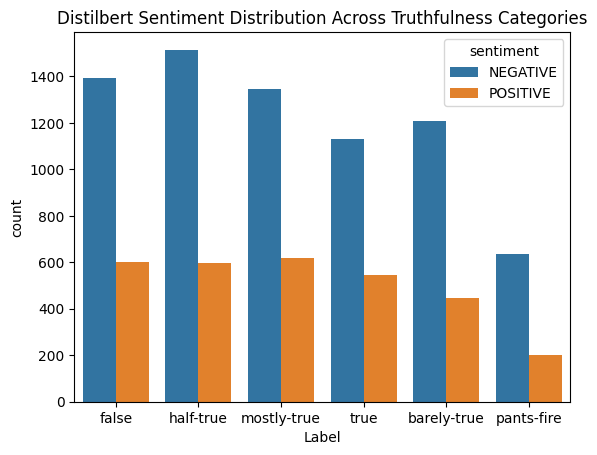

In [12]:
sns.countplot(data=liar_data, x='Label', hue='sentiment')
plt.title('Distilbert Sentiment Distribution Across Truthfulness Categories')
plt.show()

sentiment    POSITIVE  NEGATIVE  POSITIVE_to_NEGATIVE_ratio
Label                                                      
barely-true       445      1209                    0.368073
false             601      1394                    0.431133
half-true         599      1515                    0.395380
mostly-true       618      1344                    0.459821
pants-fire        203       636                    0.319182
true              546      1130                    0.483186


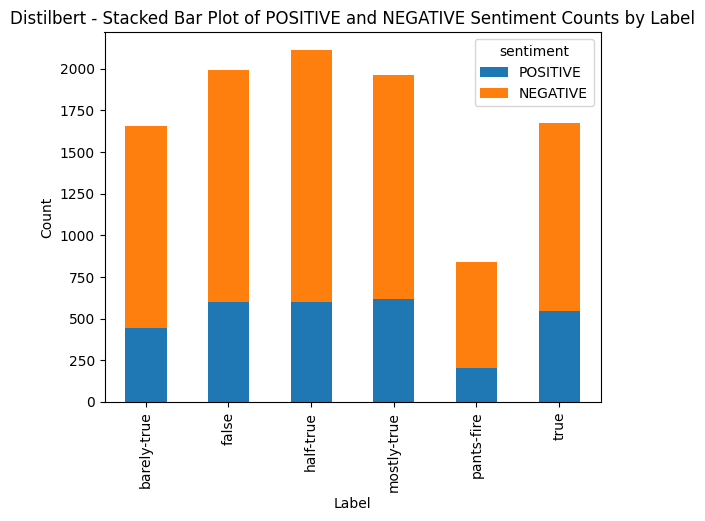

In [29]:
# Group by Label and sentiment_label and count occurrences
sentiment2_counts = liar_data.groupby(['Label', 'sentiment']).size().unstack(fill_value=0)

# Calculate the ratio of POSITIVE to NEGATIVE sentiment for each label
sentiment2_counts['POSITIVE_to_NEGATIVE_ratio'] = sentiment2_counts['POSITIVE'] / sentiment2_counts['NEGATIVE']

# Display the result
print(sentiment2_counts[['POSITIVE', 'NEGATIVE', 'POSITIVE_to_NEGATIVE_ratio']])

# Plot the ratio of POSITIVE to NEGATIVE sentiment for each label
sentiment2_counts[['POSITIVE', 'NEGATIVE']].plot(kind='bar', stacked=True)
plt.title('Distilbert - Stacked Bar Plot of POSITIVE and NEGATIVE Sentiment Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
liar_data.to_csv('su_processed_liar_data.csv', index=False)